<a href="https://colab.research.google.com/github/vinayp1120/Violence_detection_1/blob/main/Inception_ResNetViolence_detection_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Objective***:  Classify videos into violent or non-violent categories.
***Dataset***:  Obtained a labeled dataset of violent and non-violent videos.Each video is labeled with either "violent" or "non-violent".
***Preprocessing***:  Each video will be split into frames, then processed as sequences of frames.
Got Dataset from the Kaggle

In [1]:
!pip install kaggle

In [2]:
!pip install tensorflow

In [3]:
!kaggle datasets download -d karandeep98/real-life-violence-and-nonviolence-data
!unzip real-life-violence-and-nonviolence-data.zip


Streaming output truncated to the last 5000 lines.
  inflating: violence_dataset/violence/V_228.mp4_frame5.jpg  
  inflating: violence_dataset/violence/V_229.mp4_frame0.jpg  
  inflating: violence_dataset/violence/V_229.mp4_frame1.jpg  
  inflating: violence_dataset/violence/V_229.mp4_frame2.jpg  
  inflating: violence_dataset/violence/V_229.mp4_frame3.jpg  
  inflating: violence_dataset/violence/V_229.mp4_frame4.jpg  
  inflating: violence_dataset/violence/V_229.mp4_frame5.jpg  
  inflating: violence_dataset/violence/V_23.mp4_frame0.jpg  
  inflating: violence_dataset/violence/V_23.mp4_frame1.jpg  
  inflating: violence_dataset/violence/V_23.mp4_frame2.jpg  
  inflating: violence_dataset/violence/V_23.mp4_frame3.jpg  
  inflating: violence_dataset/violence/V_23.mp4_frame4.jpg  
  inflating: violence_dataset/violence/V_230.mp4_frame0.jpg  
  inflating: violence_dataset/violence/V_230.mp4_frame1.jpg  
  inflating: violence_dataset/violence/V_230.mp4_frame2.jpg  
  inflating: violence_da

In [4]:
!cd /content/violence_dataset
!mv violence_dataset /content/drive/MyDrive/kaggledataset

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
# Directory where your dataset is stored
data_dir = '/content/drive/MyDrive/kaggledataset/violence_dataset'
categories = ['violence', 'non_violence']

# Image dimensions
img_height = 224
img_width = 224


In [7]:
# Load dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    subset='training'  # Use subset='training' for training data
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    subset='validation'  # Use subset='validation' for validation data
)


Found 8851 images belonging to 2 classes.
Found 2212 images belonging to 2 classes.


Architecture 2: Inception-ResNet

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def build_inception_resnet_model(input_shape):
    # Load the InceptionResNetV2 model pre-trained on ImageNet (without fully connected layers)
    inception_resnet_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze InceptionResNetV2 layers to prevent retraining
    for layer in inception_resnet_base.layers:
        layer.trainable = False

    # Functional API model
    inputs = tf.keras.Input(shape=input_shape)
    x = inception_resnet_base(inputs, training=False)  # Apply InceptionResNetV2 base
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [9]:
# Input shape: (height, width, channels)
input_shape = (img_height, img_width, 3)  # 3 channels (RGB)

# Build and compile the model
model = build_inception_resnet_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,915,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,252,322 (226.03 MB)

 Trainable params: 4,915,586 (18.75 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


276/276 ━━━━━━━━━━━━━━━━━━━━ 195s 360ms/step - accuracy: 0.7663 - loss: 3.0650 - val_accuracy: 0.8514 - val_loss: 0.3523
Epoch 2/10
  1/276 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - accuracy: 0.8750 - loss: 0.2696

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8750 - loss: 0.2696 - val_accuracy: 0.7500 - val_loss: 0.5158
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 76s 271ms/step - accuracy: 0.9164 - loss: 0.2078 - val_accuracy: 0.8795 - val_loss: 0.2786
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 1.0000 - loss: 0.1232 - val_accuracy: 1.0000 - val_loss: 0.0430
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 76s 268ms/step - accuracy: 0.9380 - loss: 0.1576 - val_accuracy: 0.8256 - val_loss: 0.5156
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.8750 - loss: 0.2411 - val_accuracy: 0.5000 - val_loss: 0.7994
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 75s 268ms/step - accuracy: 0.9439 - loss: 0.1340 - val_accuracy: 0.8678 - val_loss: 0.4070
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - accuracy: 0.9375 - loss: 0.2059 - val_accuracy: 1.0000 - val_loss: 0.0103
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 275ms/step - accuracy: 0.9546 - loss: 0.1119 - val_accu

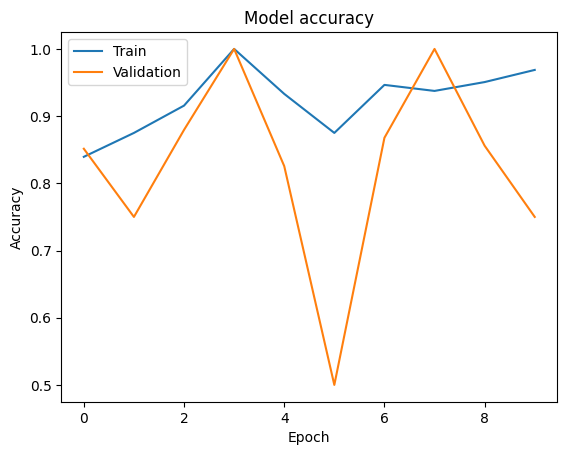

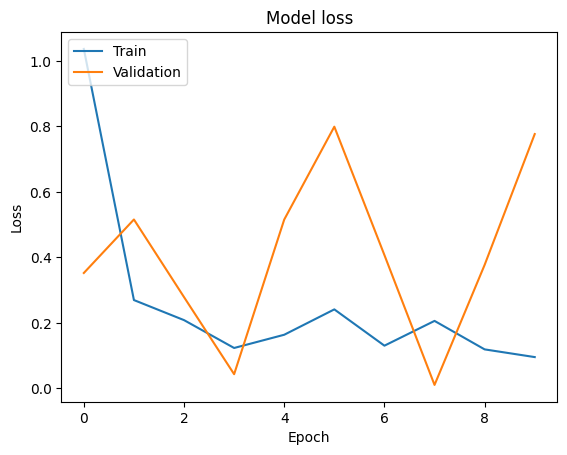

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
model.save('/content/drive/MyDrive/kaggle_violence/kaggle_violence_detection_Inception-ResNet.keras')

In [17]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/kaggle_violence/kaggle_violence_detection_Inception-ResNet.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - accuracy: 0.8444 - loss: 0.4352
Validation Loss: 0.4250551164150238
Validation Accuracy: 0.8458408713340759
